# Identify the impact of an event in a particular area  


> 👋 Before moving on with this demo, you must first sign-up and request your Geosys APIs credentials here :
> - ⚙️[Try it now](https://earthdailyagro.com/geosys-registration/)

> For more information about our Geosys APIs : 
> - 📚 [Geosys APIs to connect with your digital ag application](https://app.geosys.com/#/documentation)


> **Demo Project:** This demo demonstrates the ability to identify and calculate the impacted area within a given geometric region resulting from a specific event.



### @author: EarthDailyAgro


In [43]:
import sys
import os
import byoa
sys.path.append(os.path.join('..','src'))
import warnings

# Filtrer les UserWarning de Pandas
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
from byoa.cloud_storage import aws_s3, azure_blob_storage
from dateutil.relativedelta import relativedelta
from geosyspy.geosys import Region, Env
from impacted_areas_identification_processor.processor import ImpactedAreasIdentificationProcessor
from impacted_areas_identification_processor.cloud_storage_provider import CloudStorageProvider
import datetime as dt
import logging
import numpy as np
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
import matplotlib.pyplot as plt
from byoa.telemetry.log_manager.log_manager import LogManager

logger = LogManager.get_instance()
logger.setLevel(level=logging.ERROR)

geosys_logger = logging.getLogger('geosyspy')
geosys_logger.setLevel(level=logging.ERROR)
geosys_logger.addHandler(logging.NullHandler())


# read .env file
load_dotenv()

API_CLIENT_ID = os.getenv('API_CLIENT_ID')
API_CLIENT_SECRET = os.getenv('API_CLIENT_SECRET')
API_USERNAME = os.getenv('API_USERNAME')
API_PASSWORD = os.getenv('API_PASSWORD')

 ## Input data

These input parameters are utilized in the demo to identify and calculate the impacted area resulting from the specified event and threshold within the given geometric region. The input data for this example consists of the following parameters:

#### polygon: 
A geometry string in WKT format representing the geometric region of interest. This geometry defines the boundaries of the area under analysis.

#### eventDate: 
A datetime object representing the date of the event. In this case, the event date is "2022-09-15".

#### minDuration: 
An int-point value representing the minimum number between the dates to perform the impacted area analysis. In this example, the minimum duration is set to 10.

#### threshold: 
A floating-point value representing the threshold for evaluating the impact. In this example, the threshold is set to -0.15.

#### indicator: 
A vegetation index. In this example, the indicator is set to VegetationIndex.NDVI.


In [6]:
input_data ={
    "parameters": {
        "polygon": "POLYGON((-93.96113724989586 44.473577981244325,-93.95521493239097 44.474925388980246,-93.95049424452476 44.473057383559784,-93.94929261488609 44.4702093257966,-93.94903512282066 44.46641169924883,-93.95272584242515 44.46604417388972,-93.96010728163414 44.46616668259985,-93.96233887953453 44.46849429924204,-93.96113724989586 44.473577981244325))",
        "eventDate": "2022-09-15",
        "minDuration": 1,
        "threshold": -0.15
    },
    "indicator": "NDVI"
}

# 3️⃣ Trigger the processor with metrics. Upload result on AWS S3

Calculate and retrieve the impacted area based on a specified threshold value.
Result is saved in a zarr file pushed on a AWS S3 bucket

In [44]:
client = ImpactedAreasIdentificationProcessor(input_data,
                           username = API_USERNAME,
                           password = API_PASSWORD,
                           client_id = API_CLIENT_ID,
                           client_secret = API_CLIENT_SECRET,
                           aws_s3_bucket="byoa-demo",
                           cloud_storage_provider=CloudStorageProvider.AWS,
                           entity_id="test_byoa",
                           metrics=True,
                           clean_local_file=False)

result = client.trigger()
result

2022-09-11 2022-09-21
The highest resolution's image grid size is (107, 101)


{'storage_links': 's3://byoa-demo/test_byoa_2024-03-05_14-02-51_impacted-area-datacube.zarr',
 'results': {'before_event_date': '2022-9-11',
  'after_event_date': '2022-9-21',
  'impacted_area_percentage': '46.33 %',
  'impacted_area': '  390862.518 m²'},
 'metrics': {'execution_time': '0 minutes 13 seconds',
  'datacube_generation_network_use': '74.855 Gb',
  'datacube_upload_network_use': '0.001 Gb'}}

### Retrieve the impacted area (xarray)


In [40]:
zarr_path = client.zarr_path
vi_impacted_area = xr.open_zarr(zarr_path)
vi_impacted_area

<xarray.Dataset> Size: 88kB
Dimensions:                  (y: 101, x: 107)
Coordinates:
    crs                      <U9 36B ...
    geometry_size_px         int32 4B ...
    image.sensor             <U10 40B ...
    image.soilMaterial       <U10 40B ...
    image.spatialResolution  float64 8B ...
    image.weather            <U3 12B ...
  * x                        (x) float64 856B -93.96 -93.96 ... -93.95 -93.95
  * y                        (y) float64 808B 44.48 44.47 44.47 ... 44.47 44.47
Data variables:
    ndvi                     (y, x) float64 86kB ...

### Retrieve the impacted area (area and %)

In [13]:
print(f"# Impacted area: {result['results']['impacted_area']}")
print(f"# Impacted area percentage: {result['results']['impacted_area_percentage']}")

# Impacted area:   390862.518 m²
# Impacted area percentage: 46.33 %


##  4️⃣ Display the results
Visualize the results using matplotlib by displaying the vegetation index of the image just before the event date, the image after the event date, and the impacted area.

### Call the coverage for the area and retrieve images before and after the event date

To obtain coverage information for the area of interest, make a call to retrieve satellite images captured before and after the event date.

In [21]:
event_date = datetime.strptime(input_data['parameters']['eventDate'], '%Y-%m-%d')
coverage_info_df, images_references = client.get_image_coverage_info_based_on_map_reference(input_data['parameters']['polygon'],event_date )

image_date_list = pd.to_datetime(coverage_info_df['image.date']).dt.date

### Retrieve vegetation index images before and after the specified event date 

Retrieve the Vegetation Index images captured before and after the specified event date

In [30]:
nearest_event_date = client.find_nearest_dates(event_date,input_data['parameters']['minDuration'], image_date_list)

vi_images_nearest_event_date = client.get_vi_image_time_series(input_data['parameters']['polygon'],
                                                               nearest_event_date["before_event_date"],
                                                               nearest_event_date["after_event_date"],
                                                               input_data['indicator'])

vi_before_event_date = vi_images_nearest_event_date.sel(time=str(nearest_event_date["before_event_date"]))[input_data['indicator'].lower()]

vi_after_event_date = vi_images_nearest_event_date.sel(time=str(nearest_event_date["after_event_date"]))[input_data['indicator'].lower()]

2022-09-11 2022-09-21
The highest resolution's image grid size is (107, 101)


C:\Users\jpn\AppData\Local\Temp\ipykernel_28128\1675230634.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  vi_before_event_date_image= vi_before_event_date.squeeze().drop(['time', 'band'])
C:\Users\jpn\AppData\Local\Temp\ipykernel_28128\1675230634.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  vi_after_event_date_image= vi_after_event_date.squeeze().drop(['time', 'band'])


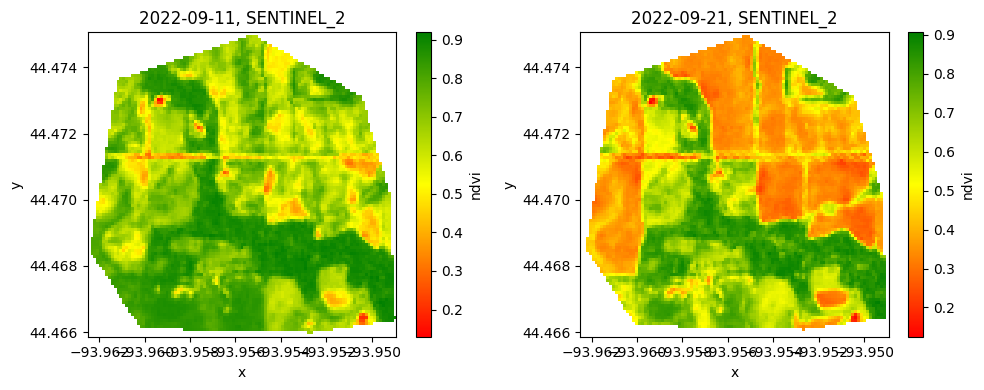

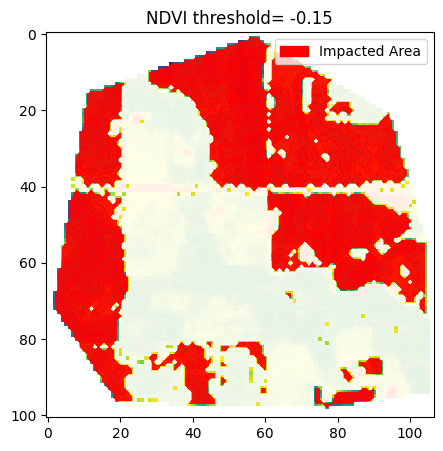

In [42]:
# Select only x and y dimension to display indicator vegetation index 
vi_before_event_date_image= vi_before_event_date.squeeze().drop(['time', 'band'])
vi_after_event_date_image= vi_after_event_date.squeeze().drop(['time', 'band'])


fig, ax = plt.subplots(1, 2, figsize=(10,4))
colors =['red', 'yellow', 'green']
cmap =  LinearSegmentedColormap.from_list(['red_green'],colors)
vi_before_event_date_image.plot(ax=ax[0], cmap = cmap)
ax[0].set_title(f"{np.datetime_as_string(vi_before_event_date['time'].values, unit='D')}, {vi_before_event_date['image.sensor'].values}")

vi_after_event_date_image.plot(ax=ax[1],  cmap = cmap)
ax[1].set_title(f"{np.datetime_as_string(vi_after_event_date['time'].values, unit='D')}, {vi_after_event_date['image.sensor'].values}")

fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=(5,5))
plt.imshow(vi_after_event_date_image,  cmap = cmap, alpha = 0.1)
plt.imshow(vi_impacted_area['ndvi'], aspect = 'auto')
plt.title(f"{input_data['indicator']} threshold= {input_data['parameters']['threshold']}")
plt.contourf(vi_impacted_area['ndvi'], colors = 'red', alpha = 0.9)
plt.legend(handles=[plt.Rectangle((0,0),1,1, color = 'red')], labels=['Impacted Area'])